<div style="text-align: right" align="right"><i>Peter Norvig<br>December 1–25, 2021</i></div>

# Advent of Code 2021

I'm doing [Advent of Code](https://adventofcode.com/2021) (AoC) this year. I'm not competing for points, just participating for fun.

To fully understand each puzzle's instructions, click on the link (e.g. [**Day 1**](https://adventofcode.com/2021/day/1)); I give only brief summaries here. 

Part of the idea of AoC is that you have to make some design choices to solve Part 1 *before* you get to see the instructions for Part 2. So there is a tension of wanting the solution to Part 1 to provide components that can be re-used in Part 2, without falling victim to [YAGNI](https://en.wikipedia.org/wiki/You_aren%27t_gonna_need_it). In this notebook I won't refactor the code for Part 1 after I see what is requested in Part 2 (although I may edit the code for clarity, without changing the initial approach).

# Day 0: Preparations

Imports that I have used in past AoC years:

In [1]:
from __future__  import annotations
from collections import Counter, defaultdict, namedtuple, deque
from itertools   import permutations, combinations, chain, count as count_from, product as cross_product
from typing      import *
from statistics  import mean, median
from math        import ceil, inf
from functools   import lru_cache
import matplotlib.pyplot as plt
import re

Each day's work will consist of three tasks, denoted by three bulleted section:
- **Input**: Parse the day's input file.  I will  use the function `parse(day, parser, sep)`, which:
   - Reads the input file for `day`.
   - Prints out the first few lines of the file (to remind me, and the notebook reader, what's in the file).
   - Breaks the file into a sequence of *entries* separated by `sep` (default newline).
   - Applies `parser` to each entry and returns the results as a tuple.
       - Useful parser functions include `ints`, `digits`, `atoms`, `words`, and the built-ins `int` and `str`.
- **Part 1**: Understand the day's instructions and:
   - Write code to compute the answer to Part 1.
   - Record the answer with the `answer` function, which also serves as a unit test when the notebook is re-run.
- **Part 2**: Understand the second part of the instructions and:
   - Write code and record `answer` for Part 2.
   
Occasionally I'll introduce a **Part 3** where I explore beyond the instructions.

Here are the helper functions for `answer` and `parse`:

In [2]:
def answer(puzzle_number, got, expected) -> bool:
    """Verify the answer we got was the expected answer."""
    assert got == expected, f'For {puzzle_number}, expected {expected} but got {got}.'
    return True

def parse(day, parser=str, sep='\n', print_lines=7) -> tuple:
    """Split the day's input file into entries separated by `sep`, and apply `parser` to each."""
    fname = f'AOC2021/input{day}.txt'
    text  = open(fname).read()
    entries = mapt(parser, text.rstrip().split(sep))
    if print_lines:
        all_lines = text.splitlines()
        lines = all_lines[:print_lines]
        head = f'{fname} ➜ {len(text)} chars, {len(all_lines)} lines; first {len(lines)} lines:'
        dash = "-" * 100
        print(f'{dash}\n{head}\n{dash}')
        for line in lines:
            print(trunc(line))
        print(f'{dash}\nparse({day}) ➜ {len(entries)} entries:\n'
              f'{dash}\n{trunc(str(entries))}\n{dash}')
    return entries

def trunc(s: str, left=70, right=25, dots=' ... ') -> str: 
    """All of string s if it fits; else left and right ends of s with dots in the middle."""
    dots = ' ... '
    return s if len(s) <= left + right + len(dots) else s[:left] + dots + s[-right:]

In [3]:
Char = str # Intended as the type of a one-character string
Atom = Union[float, int, str]

def ints(text: str) -> Tuple[int]:
    """A tuple of all the integers in text, ignoring non-number characters."""
    return mapt(int, re.findall(r'-?[0-9]+', text))

def digits(text: str) -> Tuple[int]:
    """A tuple of all the digits in text (as ints 0–9), ignoring non-digit characters."""
    return mapt(int, re.findall(r'[0-9]', text))

def words(text: str) -> List[str]:
    """A list of all the alphabetic words in text, ignoring non-letters."""
    return re.findall(r'[a-zA-Z]+', text)

def atoms(text: str) -> Tuple[Atom]:
    """A tuple of all the atoms (numbers or symbol names) in text."""
    return mapt(atom, re.findall(r'[a-zA-Z_0-9.+-]+', text))

def atom(text: str) -> Atom:
    """Parse text into a single float or int or str."""
    try:
        x = float(text)
        return round(x) if round(x) == x else x
    except ValueError:
        return text
    
def mapt(fn, *args) -> tuple:
    """map(fn, *args) and return the result as a tuple."""
    return tuple(map(fn, *args))

A few additional  utility functions that I have used in the past:

In [4]:
def quantify(iterable, pred=bool) -> int:
    """Count the number of items in iterable for which pred is true."""
    return sum(1 for item in iterable if pred(item))

class multimap(defaultdict):
    """A mapping of {key: [val1, val2, ...]}."""
    def __init__(self, pairs: Iterable[tuple], symmetric=False):
        """Given (key, val) pairs, return {key: [val, ...], ...}.
        If `symmetric` is True, treat (key, val) as (key, val) plus (val, key)."""
        self.default_factory = list
        for (key, val) in pairs:
            self[key].append(val)
            if symmetric:
                self[val].append(key)

def prod(numbers) -> float: # Will be math.prod in Python 3.8
    """The product formed by multiplying `numbers` together."""
    result = 1
    for x in numbers:
        result *= x
    return result

def total(counter: Counter) -> int: 
    """The sum of all the counts in a Counter."""
    return sum(counter.values())

def sign(x) -> int: return (0 if x == 0 else +1 if x > 0 else -1)

def transpose(matrix) -> list: return list(zip(*matrix))

def nothing(*args) -> None: return None

cat     = ''.join
flatten = chain.from_iterable
cache   = lru_cache(None)

Some past puzzles involve (x, y) points on a rectangular grid, so I'll define  `Point` and `Grid`:

In [5]:
Point = Tuple[int, int] # (x, y) points on a grid

neighbors4 = ((0, 1), (1, 0), (0, -1), (-1, 0))               
neighbors8 = ((1, 1), (1, -1), (-1, 1), (-1, -1)) + neighbors4

class Grid(dict):
    """A 2D grid, implemented as a mapping of {(x, y): cell_contents}."""
    def __init__(self, mapping=(), rows=(), neighbors=neighbors4):
        """Initialize with, e.g., either `mapping={(0, 0): 1, (1, 0): 2, ...}`,
        or `rows=[(1, 2, 3), (4, 5, 6)].
        `neighbors` is a collection of (dx, dy) deltas to neighboring points.`"""
        self.update(mapping if mapping else
                    {(x, y): val 
                     for y, row in enumerate(rows) 
                     for x, val in enumerate(row)})
        self.width  = max(x for x, y in self) + 1
        self.height = max(y for x, y in self) + 1
        self.deltas = neighbors
        
    def copy(self) -> Grid: return Grid(self, neighbors=self.deltas)
    
    def neighbors(self, point) -> List[Point]:
        """Points on the grid that neighbor `point`."""
        x, y = point
        return [(x+dx, y+dy) for (dx, dy) in self.deltas 
                if (x+dx, y+dy) in self]
    
    def to_rows(self) -> List[List[object]]:
        """The contents of the grid in a rectangular list of lists."""
        return [[self[x, y] for x in range(self.width)]
                for y in range(self.height)]

This year's AoC theme involves Santa's Elves on a submarine. [Gary J Grady](https://twitter.com/GaryJGrady/) has some nice drawings to set the scene:

<img src="https://pbs.twimg.com/media/FFiywKpWYAAm6B5?format=jpg&name=medium" width=400>

# [Day 1](https://adventofcode.com/2021/day/1): Sonar Sweep


- **Input**: Each entry in the input is an integer depth measurement.


In [6]:
in1 = parse(1, int)

----------------------------------------------------------------------------------------------------
AOC2021/input1.txt ➜ 9756 chars, 2000 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
148
167
168
169
182
188
193
----------------------------------------------------------------------------------------------------
parse(1) ➜ 2000 entries:
----------------------------------------------------------------------------------------------------
(148, 167, 168, 169, 182, 188, 193, 209, 195, 206, 214, 219, 225, 219, ... , 5604, 5623, 5626, 5625)
----------------------------------------------------------------------------------------------------


- **Part 1**: How many measurements are larger than the previous measurement?

In [7]:
def increases(nums: List[int]) -> int:
    """How many measurements are larger than the previous measurement?"""
    return quantify(nums[i] > nums[i - 1] 
                    for i in range(1, len(nums)))

answer(1.1, increases(in1), 1400)

True

- **Part 2**: Consider sums of a three-measurement sliding window. How many sums are larger than the previous sum?

In [8]:
def window_increases(nums: List[int], w=3) -> int:
    """How many sliding windows of `w` numbers have a sum larger than the previous window?"""
    return quantify(sum(nums[i:i+w]) > sum(nums[i-1:i-1+w])
                    for i in range(1, len(nums) + 1 - w))

answer(1.2, window_increases(in1), 1429)

True

- **Part 3**: Visualization

Let's take a look at where the depths are taking us:

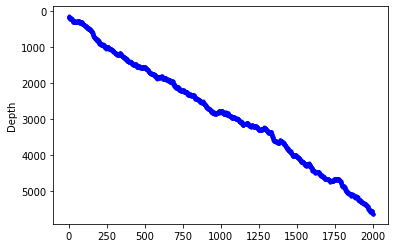

In [9]:
plt.plot(in1, 'b.'); plt.ylabel('Depth'); plt.gca().invert_yaxis();

It looks like Gary Grady was right; the submarine is descending at a steep angle.

# [Day 2](https://adventofcode.com/2021/day/2): Dive! 

- **Input**: Each entry in the input is a command name ("forward", "down", or "up") followed by an integer.

I'll parse a command into a tuple like `('forward', 2)`.

In [10]:
in2 = parse(2, atoms)

----------------------------------------------------------------------------------------------------
AOC2021/input2.txt ➜ 7723 chars, 1000 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
forward 2
down 7
down 8
forward 9
down 8
forward 9
forward 8
----------------------------------------------------------------------------------------------------
parse(2) ➜ 1000 entries:
----------------------------------------------------------------------------------------------------
(('forward', 2), ('down', 7), ('down', 8), ('forward', 9), ('down', 8) ... ard', 3), ('forward', 6))
----------------------------------------------------------------------------------------------------


- **Part 1**: Calculate the horizontal position and depth you would have after following the planned course. What do you get if you multiply your final horizontal position by your final depth?

In [11]:
def drive(commands) -> int:
    """What is the product of position and depth after following commands?"""
    pos = depth = 0
    for (op, n) in commands:
        if op == 'forward': pos += n
        if op == 'down':    depth += n
        if op == 'up':      depth -= n
    return pos * depth

answer(2.1, drive(in2), 1_670_340)

True

- **Part 2**: Using the new interpretation of the commands, calculate the horizontal position and depth you would have after following the planned course. What do you get if you multiply your final horizontal position by your final depth? 

The *new interpretation* is that the "down" and "up" commands no longer change depth, rather they change *aim*, and going forward *n* units both increments position by *n* and depth by *aim* × *n*.

In [12]:
def drive2(commands) -> int:
    """What is the product of position and depth after following commands?
    This time we have to keep track of `aim` as well."""
    pos = depth = aim = 0
    for (op, n) in commands:
        if op == 'forward': pos += n; depth += aim * n
        if op == 'down':    aim += n
        if op == 'up':      aim -= n
    return pos * depth

answer(2.2, drive2(in2), 1_954_293_920)

True

# [Day 3](https://adventofcode.com/2021/day/3): Binary Diagnostic

- **Input**: Each entry in the input is a bit string of `0`s and `1`s.

I'll parse them as strings; I won't convert them into ints.

In [13]:
in3 = parse(3)

----------------------------------------------------------------------------------------------------
AOC2021/input3.txt ➜ 13000 chars, 1000 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
101000111100
000011111101
011100000100
100100010000
011110010100
101001100000
110001010000
----------------------------------------------------------------------------------------------------
parse(3) ➜ 1000 entries:
----------------------------------------------------------------------------------------------------
('101000111100', '000011111101', '011100000100', '100100010000', '0111 ... 1100111', '110111100100')
----------------------------------------------------------------------------------------------------


- **Part 1**: Use the binary numbers in your diagnostic report to calculate the gamma rate and epsilon rate, then multiply them together. What is the power consumption of the submarine?

In [14]:
def common(strs, i) -> Char: # '1' or '0'
    """The bit that is most common in position i among strs."""
    bits = [s[i] for s in strs]
    return '1' if bits.count('1') >= bits.count('0') else '0'

def uncommon(strs, i) -> Char: # '1' or '0'
    """The bit that is least common in position i among strs."""
    return '1' if common(strs, i) == '0' else '0'

def epsilon(strs) -> str:
    """The bit string formed from most common bit at each position."""
    return cat(common(strs, i) for i in range(len(strs[0])))

def gamma(strs) -> str:
    """The bit string formed from most uncommon bit at each position."""
    return cat(uncommon(strs, i) for i in range(len(strs[0])))

def power(strs) -> int: 
    """Product of epsilon and gamma rates."""
    return int(epsilon(strs), 2) * int(gamma(strs), 2)
    
answer(3.1, power(in3), 2261546)

True

- **Part 2**: Use the binary numbers in your diagnostic report to calculate the oxygen generator rating and CO2 scrubber rating, then multiply them together. What is the life support rating of the submarine?

This time I'll have a single function, `select_str` which selects the str that survives the process of picking strs with the most common or uncommon bit at each position. Then I call `select_str` with `common` to get the oxygen rating and `uncommon` to get the CO2 rating.

In [15]:
def select_str(strs, common_fn, i=0) -> str:
    """Select a str from strs according to common_fn:
    Going left-to-right, repeatedly select just the strs that have the right i-th bit.
    When only one string is remains, return it."""
    if len(strs) == 1:
        return strs[0]
    else:
        bit = common_fn(strs, i)
        selected = [s for s in strs if s[i] == bit]
        return select_str(selected, common_fn, i + 1)

def life_support(strs) -> int: 
    """The product of oxygen (most common select) and CO2 (least common select) rates."""
    return int(select_str(strs, common), 2) * int(select_str(strs, uncommon), 2)
    
answer(3.2, life_support(in3), 6775520)

True

# [Day 4](https://adventofcode.com/2021/day/4): Giant Squid

- **Input**: The first entry of the input is a permutation of the integers 0-99. Subsequent entries are bingo boards: 5 lines of 5 ints each. Entries are separated by *two* newlines. 

I'll represent a board as a tuple of 25 ints; that makes `parse` easy: the permutation of integers and the bingo boards can both be parsed by `ints`. (Bingo games will be played against a giant squid; we get to choose which board we want to play.)

In [16]:
order, *boards = in4 = parse(4, ints, sep='\n\n')

----------------------------------------------------------------------------------------------------
AOC2021/input4.txt ➜ 7890 chars, 601 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
73,42,95,35,13,40,99,92,33,30,83,1,36,93,59,90,55,25,77,44,37,62,41,47 ... 7,84,86,45,75,60,15,14,11

91  5 64 81 34
15 99 31 63 65
45 39 54 93 83
51 14 23 86 32
19 22 16 13  3
----------------------------------------------------------------------------------------------------
parse(4) ➜ 101 entries:
----------------------------------------------------------------------------------------------------
((73, 42, 95, 35, 13, 40, 99, 92, 33, 30, 83, 1, 36, 93, 59, 90, 55, 2 ...  69, 17, 49, 91, 30, 33))
----------------------------------------------------------------------------------------------------


- **Part 1**: What will your final score be if you choose the first bingo board to win?

I'm worried about an ambiguity: what if two boards win at the same time? I'll have to assume Eric arranged it so that can't happen. I'll define `bingo_winners` to return a list of boards that win when a number has just been called, and I'll arbitrarily choose the first of them.

In [17]:
B     = 5 # Bingo board is size B by B.
Board = Tuple[int] # B * B ints
Line  = List[int]  # B ints

def lines(square) -> Tuple[Line, Line]:
    """The two lines (horizontal and vertical) through square number `square`."""
    def sq(x, y) -> int: return x + B * y
    return ([sq(x, square // B) for x in range(B)], 
            [sq(square % B, y)  for y in range(B)])

def bingo_winners(boards, drawn, just_called) -> List[Board]:
    """Board(s) that win due to the number just called."""
    def filled(board, line) -> bool: return all(board[n] in drawn for n in line)
    return [board for board in boards
            if just_called in board
            and any(filled(board, line) 
                    for line in lines(board.index(just_called)))]

def bingo_score(board, drawn, just_called) -> int:
    """Sum of unmarked numbers multiplied by the number just called."""
    unmarked = sum(n for n in board if n not in drawn)
    return unmarked * just_called

def bingo(boards, order) -> int: 
    """What is the final score of the first winning board?"""
    drawn = set()
    for num in order:
        drawn.add(num)
        winners = bingo_winners(boards, drawn, num)
        if winners:
            return bingo_score(winners[0], drawn, num)

answer(4.1, bingo(boards, order), 39902)

True

- **Part 2**: Figure out which board will win last. Once it wins, what would its final score be?

In [18]:
def bingo_last(boards, order) -> int: 
    """What is the final score of the last winning board?"""
    remaining_boards = set(boards)
    drawn = set()
    for num in order:
        drawn.add(num)
        winners = bingo_winners(remaining_boards, drawn, num)
        remaining_boards -= set(winners)
        if not remaining_boards:
            return bingo_score(winners[-1], drawn, num)
                
answer(4.2, bingo_last(boards, order), 26936)

True

<img src="https://pbs.twimg.com/media/FFykNslXMAwe_xA?format=jpg&name=medium" width=400 title="Drawing by Gary Grady @GaryJGrady">

# [Day 5](https://adventofcode.com/2021/day/5): Hydrothermal Venture

- **Input**: Each entry in the input is a "line" denoted by start and end x,y points, e.g. "`0,9 -> 5,9`". 

I'll represent a line as a 4-tuple of integers, e.g. `(0, 9, 5, 9)`.

In [19]:
in5 = parse(5, ints)

----------------------------------------------------------------------------------------------------
AOC2021/input5.txt ➜ 9249 chars, 500 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
409,872 -> 409,963
149,412 -> 281,280
435,281 -> 435,362
52,208 -> 969,208
427,265 -> 884,265
779,741 -> 779,738
949,41 -> 13,977
----------------------------------------------------------------------------------------------------
parse(5) ➜ 500 entries:
----------------------------------------------------------------------------------------------------
((409, 872, 409, 963), (149, 412, 281, 280), (435, 281, 435, 362), (52 ... 13), (919, 123, 88, 954))
----------------------------------------------------------------------------------------------------


- **Part 1**: Consider only horizontal and vertical lines. At how many points do at least two lines overlap?

In [20]:
def points(line) -> List[Point]:
    """All the (integer) points on a line."""
    x1, y1, x2, y2 = line
    if x1 == x2:
        return [(x1, y) for y in cover(y1, y2)]
    elif y1 == y2:
        return [(x, y1) for x in cover(x1, x2)]
    else: # non-orthogonal lines not allowed
        return []
    
def overlaps(lines) -> int:
    """How many points overlap 2 or more lines?"""
    counts = Counter(flatten(map(points, lines)))
    return quantify(counts[p] >= 2 for p in counts)

def cover(*xs) -> range:
    """All the ints from the min of the arguments to the max, inclusive."""
    return range(min(xs), max(xs) + 1)

answer(5.1, overlaps(in5), 7436)

True

- **Part 2**: Consider all of the lines (including diagonals, which are all at ±45°). At how many points do at least two lines overlap?

For Part 2 I'll redefine `points` and `overlaps` in a way that doesn't break Part 1:

In [21]:
def points(line, diagonal=False) -> bool:
    """All the (integer) points on a line; optionally allow diagonal lines."""
    x1, y1, x2, y2 = line
    if diagonal or x1 == x2 or y1 == y2:
        dx, dy = sign(x2 - x1), sign(y2 - y1)
        length = max(abs(x2 - x1), abs(y2 - y1))
        return [(x1 + k * dx, y1 + k * dy) for k in range(length + 1)]
    else: # non-orthogonal lines not allowed when diagonal is False
        return []
    
def overlaps(lines, diagonal=False) -> int:
    """How many points overlap 2 or more lines?"""
    counts = Counter(flatten(points(line, diagonal) for line in lines))
    return quantify(counts[p] >= 2 for p in counts)

assert points((1, 1, 1, 3), False) == [(1, 1), (1, 2), (1, 3)]
assert points((1, 1, 3, 3), False) == []
assert points((1, 1, 3, 3), True) == [(1, 1), (2, 2), (3, 3)]
assert points((9, 7, 7, 9), True) == [(9, 7), (8, 8), (7, 9)]

answer(5.1, overlaps(in5, False), 7436)
answer(5.2, overlaps(in5, True), 21104)

True

# [Day 6](https://adventofcode.com/2021/day/6): Lanternfish

- **Input**: The input is comma-separated integers, each the age of a lanternfish. Over time, the lanternfish age and reproduce in a specified way.

In [22]:
in6 = parse(6, int, sep=',')

----------------------------------------------------------------------------------------------------
AOC2021/input6.txt ➜ 600 chars, 1 lines; first 1 lines:
----------------------------------------------------------------------------------------------------
5,4,3,5,1,1,2,1,2,1,3,2,3,4,5,1,2,4,3,2,5,1,4,2,1,1,2,5,4,4,4,1,5,4,5, ... 5,5,1,3,1,4,2,3,3,1,4,1,1
----------------------------------------------------------------------------------------------------
parse(6) ➜ 300 entries:
----------------------------------------------------------------------------------------------------
(5, 4, 3, 5, 1, 1, 2, 1, 2, 1, 3, 2, 3, 4, 5, 1, 2, 4, 3, 2, 5, 1, 4,  ... , 4, 2, 3, 3, 1, 4, 1, 1)
----------------------------------------------------------------------------------------------------


- **Part 1**: Find a way to simulate lanternfish. How many lanternfish would there be after 80 days?

Although the puzzle instructions treats each fish individually, I won't take the bait (pun intended). 

Instead, I'll use a `Counter` of fish, and process all the fish of each age group together, all at once. That way each update will be *O*(1), not *O*(*n*). I have a hunch that Part 2 will involve a ton-o'-fish.

In [23]:
Fish = Counter # Represent a school of fish as a Counter of their timer-ages

def simulate(fish, days=1) -> Fish:
    """Simulate the aging and birth of fish over `days`."""
    for day in range(days):
        fish = Fish({t - 1: fish[t] for t in fish})
        if -1 in fish: # births
            fish[6] += fish[-1]
            fish[8] = fish[-1]
            del fish[-1]
    return fish
        
assert simulate(Fish((3, 4, 3, 1, 2))) == Fish((2, 3, 2, 0, 1))
assert simulate(Fish((2, 3, 2, 0, 1))) == Fish((1, 2, 1, 6, 0, 8))

answer(6.1, total(simulate(Fish(in6), 80)), 350917)

True

- **Part 2**: How many lanternfish would there be after 256 days?

My hunch was right, so part 2 is simple:

In [24]:
answer(6.2, total(simulate(Fish(in6), 256)), 1_592_918_715_629)

True

That's over a trillion lanternfish. Latest [estimates](https://www.google.com/search?q=how+many+fish+are+in+the+sea) say that there are in fact trillions of fish in the sea. But not trillions of lanternfish, and not increasing from 300 to over a trillion in just 256 days.

<img src="https://pbs.twimg.com/media/FF9GGGJXEAEQ0MD?format=jpg&name=medium" width=400 title="Drawing by Gary Grady @GaryJGrady">

# [Day 7](https://adventofcode.com/2021/day/7): The Treachery of Whales

- **Input**: The input is a single line of comma-separated integers, each  the horizontal position of a crab (in its own submarine).

In [25]:
in7 = parse(7, int, sep=',')

----------------------------------------------------------------------------------------------------
AOC2021/input7.txt ➜ 3887 chars, 1 lines; first 1 lines:
----------------------------------------------------------------------------------------------------
1101,1,29,67,1102,0,1,65,1008,65,35,66,1005,66,28,1,67,65,20,4,0,1001, ... 684,51,1186,1801,627,1379
----------------------------------------------------------------------------------------------------
parse(7) ➜ 1000 entries:
----------------------------------------------------------------------------------------------------
(1101, 1, 29, 67, 1102, 0, 1, 65, 1008, 65, 35, 66, 1005, 66, 28, 1, 6 ... 1, 1186, 1801, 627, 1379)
----------------------------------------------------------------------------------------------------


The idea is that if the crabs can all align in one horizontal position, they can save you from a giant whale.

- **Part 1**: Determine the horizontal position that the crabs can align to using the least fuel possible.  How much fuel must they spend to align to that position? (Each unit of horizontal travel costs one unit of fuel.)

In [26]:
def fuel_cost(positions) -> int:
    """How much fuel does it cost to get everyone to the best alignment point?"""
    # I happen to know that the best alignment point is the median
    align = median(positions)
    return sum(abs(p - align) for p in positions)

answer(7.1, fuel_cost(in7), 352707)

True

- **Part 2**: Determine the horizontal position that the crabs can align to using the least fuel possible so they can make you an escape route! How much fuel must they spend to align to that position? (Now for each crab the first unit of travel costs 1, the second 2, the third 3, and so on.) 

In [27]:
def fuel_cost2(positions) -> int:
    """How much fuel does it cost to get everyone to the best alignment point, 
    with nonlinear fuel costs?"""
    # I don't know the best alignment point, so I'll try all of them
    return min(sum(burn_rate2(p, align) for p in positions)
               for align in range(min(positions), max(positions) + 1))

def burn_rate2(p, align) -> int:
    """The first step costs 1, the second 2, etc. (i.e. triangular numbers)."""
    steps = abs(p - align)
    return steps * (steps + 1) // 2

answer(7.2, fuel_cost2(in7), 95519693)

True

- **Part 3**: Analysis and Visualization

Now that I got the right answer and have some time to think about it, if the travel cost were exactly quadratic, we would be minimizing the sum of square distances, and Legendre and Gauss knew that the **mean**, not the **median**, is the alignment point that does that. What's the mean of the positions?

In [28]:
positions = in7
mean(positions)

490.543

That's not an integer, but I'll try it, along with the integers above and below it:

In [29]:
{align: sum(burn_rate2(p, align) for p in positions)
 for align in [490, 491, mean(positions)]}

{490: 95519693, 491: 95519725, 490.543: 95519083.0}

We see that rounding down gives the right answer, rounding up does a bit worse, and using the exact mean  gives a total fuel cost that is *better* than the correct answer (but is apparently not a legal alignment point). A reddit user with the name CrashAndSideburns looked more carefully into the use of the mean, and wrote [a paper](https://www.reddit.com/r/adventofcode/comments/rawxad/2021_day_7_part_2_i_wrote_a_paper_on_todays/) showing that the best alignment point must be within ±0.5 from the mean.

Below I show a histogram of the number of crabs at each range of horizontal positions, along with red stars for the two alignment points (median and mean).

[376.0, 490.543]

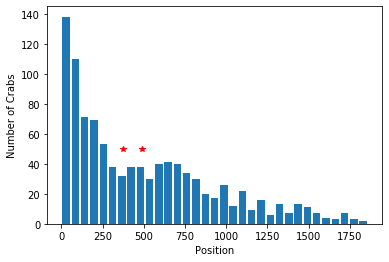

In [30]:
stars = [median(in7), mean(in7)]
plt.hist(in7, bins=33, rwidth=0.8); 
plt.plot(stars, [50, 50], 'r*')
plt.ylabel('Number of Crabs'); plt.xlabel('Position')
stars

<img src="https://pbs.twimg.com/media/FGCMbMhXMA8zAJD?format=jpg&name=medium" width=400 title="@GaryJGrady">

# [Day 8](https://adventofcode.com/2021/day/8): Seven Segment Search

- **Input**: Each entry in the input consists of 10 patterns followed by a "`|`", followed by 4 output values.
      
Each pattern and output value represents a digit on a [7-segment display](https://en.wikipedia.org/wiki/Seven-segment_display), with each letter a–g representing one of the 7 segments. The mapping of letters to segments is unknown, but is consistent within each entry.

In [31]:
in8 = parse(8, lambda line: mapt(atoms, line.split('|')))

----------------------------------------------------------------------------------------------------
AOC2021/input8.txt ➜ 16614 chars, 200 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
daegb gadbcf cgefda edcfagb dfg acefbd fdgab fg bdcfa fcgb | cdfgba fgbc dbfac gfadbc
bdfc dcbegf bf egfbcda gebad cfgaed bfe edfgc aegfcb gebdf | fb fb bcdfaeg fcgdeb
cebdgaf bfcd gceab bf bfcea gceafd ecdfa fegdab bfcade fba | dfcb dagfbe fbaged bfa
efabcg aegcdb fgaed fac dgafbc becf eadcgbf aegfc fc cagbe | ecgfa agdef eagfc gdceab
fcdae cdeabf fga gf gabfde cgadb gadebfc cgfe aegcdf afgcd | fbgadce gadefb fag bafegd
gecadbf bgc dacgf gaecbf cbeda dbfg bgdca bg bafcgd gdacef | cdgfa fceabg dgfb dgabc
fbecdga gcdbea cegab fc cafe cfg ebgdf cbgfe afbgec bagcdf | feac acegb bfagce gcafbe
----------------------------------------------------------------------------------------------------
parse(8) ➜ 200 entries:
-----------------

In [32]:
assert in8[0] == (('daegb', 'gadbcf', 'cgefda', 'edcfagb', 'dfg', 'acefbd', 'fdgab', 'fg', 'bdcfa', 'fcgb'), 
                  ('cdfgba', 'fgbc', 'dbfac', 'gfadbc'))

<img src="https://pbs.twimg.com/media/FGHtjKiWYAQGrBX?format=jpg&name=medium" width=400 title="@GaryJGrady">

- **Part 1**: In the output values, how many times do digits 1, 4, 7, or 8 appear?

That's the same as asking *how many output values have 2, 4, 3, or 7 segments?*

In [33]:
def count1478(entries) -> int:
    """How many of the rhs digits in the entries are a 1, 4, 7, or 8?"""
    return quantify(len(value) in (2, 4, 3, 7) 
                    for (lhs, rhs) in entries for value in rhs)

answer(8.1, count1478(in8), 493)

True

- **Part 2**: For each entry, determine all of the wire/segment connections and decode the four-digit output values. What do you get if you add up all of the output values?

Part 2 is *tricky*. The first output value `'cdfgba'` could be either a 0, 6, or 9. To figure out which one it is I could do some fancy constraint satisfaction. That sounds hard. Or I could exhaustively try all permutations of the 7 letters. That sounds easy!  Here's my plan:
- Make a list of the 7! = 5,040 possible string translators that permute `'abcdefg'`.
- Decode an entry by trying all translators and keeping the one that maps all of the ten lhs patterns to a valid digit. `decode` then applies the translator to the four rhs values, concatenates them, and  converts the result into an `int`.
  - Note that `get_digit` must *sort* the translated letters to get a key that can be looked up in `segment_map`.
- Finally, sum up the decoding of each entry.

In [34]:
segments7    = 'abcdefg'
segment_map  = {'abcefg': '0', 'cf':     '1', 'acdeg': '2', 'acdfg':   '3', 'bcdf':   '4',
                'abdfg':  '5', 'abdefg': '6', 'acf':   '7', 'abcdefg': '8', 'abcdfg': '9'}

translators = [str.maketrans(segments7, cat(p)) for p in permutations(segments7)]

def get_digit(pattern, translator) -> Optional[Char]:
    """Translate the pattern, and return a digit '0' to '9' if valid."""
    return segment_map.get(cat(sorted(pattern.translate(translator))))

def decode(entry) -> int:
    """Decode an entry's rhs into a 4-digit integer."""
    lhs, rhs = entry
    for t in translators:
        if all(get_digit(pattern, t) for pattern in lhs):
            return int(cat(get_digit(pattern, t) for pattern in rhs))

answer(8.2, sum(map(decode, in8)), 1010460)

True

# [Day 9](https://adventofcode.com/2021/day/9): Smoke Basin

- **Input:** The input is a *heightmap*: a 2D array of characters '0'–'9' representing the heights on the ocean floor. 

I'll use `parse` to get a tuple of rows (where each row is a tuple of digits), and turn that into a `Grid`.

In [35]:
in9 = Grid(rows=parse(9, digits))

----------------------------------------------------------------------------------------------------
AOC2021/input9.txt ➜ 10100 chars, 100 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
9897656789865467895698765469899988672134598894345689864101378965457932349943210987654789653198789434
8789542499996878954329984398789976561012987789245678953212567892345791998899329899765678969997668912
7678943978987989965998993297649875432129876567956789864487678991056899877778939769886789998766457899
4578999868998996899867894976532986543299876476897899987569899989167898766567898654998898998655345678
2456987657679535679756799988643498657987654345789978899789998878998919954349997543219967987543237889
1234896545568986798645678999754989767898765456998769759899987765789329863238898659301256798793156891
2346789432379997987434689489899879898919876567899954346998796434678997642127789798512345989989247892
-------------------------------

- **Part 1**: Find all of the *low points* on your heightmap. What is the sum of the risk levels of all low points on your heightmap?

A low point is a point where all the neighbors are higher. The risk level is 1 more than the height of the low point.

In [36]:
def low_points(grid) -> List[Point]:
    """All low points on grid."""
    return [p for p in grid 
            if all(grid[p] < grid[nbr] for nbr in grid.neighbors(p))]

def total_risk(grid) -> int:
    """Sum of height + 1 for all low points on grid."""
    return sum(grid[p] + 1 for p in low_points(grid))

answer(9.1, total_risk(in9), 607)

True

- **Part 2**: What do you get if you multiply together the sizes of the three largest basins?
    
I thought there was an ambiguity in the definition of *basin*: what happens if there is a high point that is not of height 9, but has low points on either side of it? Wouldn't that high point then be part of two basins? The puzzle instructions says *Locations of height 9 do not count as being in any basin, and all other locations will always be part of exactly one basin.* I decided this must mean that the heightmap is carefully arranged so that every basin has only one low point and is surrounded by either edges or height 9 locations.

Given that definition of *basin,* I can associate each location with its low point using a [flood fill](https://en.wikipedia.org/wiki/Flood_fill) that starts from each low point. I can then get the sizes of the three largest (most common) basins and multiply them together.

In [37]:
def find_basins(grid) -> Dict[Point, Point]:
    """Compute `basins` as a map of {point: low_point} for each point in grid."""
    basins = {} # A dict mapping each non-9 location to its low point.
    def flood_fill(p, low):
        """Spread from p in all directions until hitting a 9;
        mark each point p as being part of the basin with `low` point."""
        if grid[p] < 9 and p not in basins:
            basins[p] = low
            for p2 in grid.neighbors(p):
                flood_fill(p2, low)
    for p in low_points(grid):
        flood_fill(p, low=p)
    return basins

def flood_size_products(grid, b=3) -> int:
    """The product of the sizes of the `b` largest basins."""
    basins = find_basins(grid)
    return prod(c for _, c in Counter(basins.values()).most_common(b))

answer(9.2, flood_size_products(in9), 900864)

True

- **Part 3**: Verification and Visualization

I want to check that the set of low points is the same as the set of basins I identified:

In [38]:
assert set(low_points(in9)) == set(find_basins(in9).values())

len(low_points(in9))

249

I would also like to visualize the basins. I'll use a scatter plot  that displays the height 9 locations in yellow and the height 0 locations in deep purple, with a gradient in between:

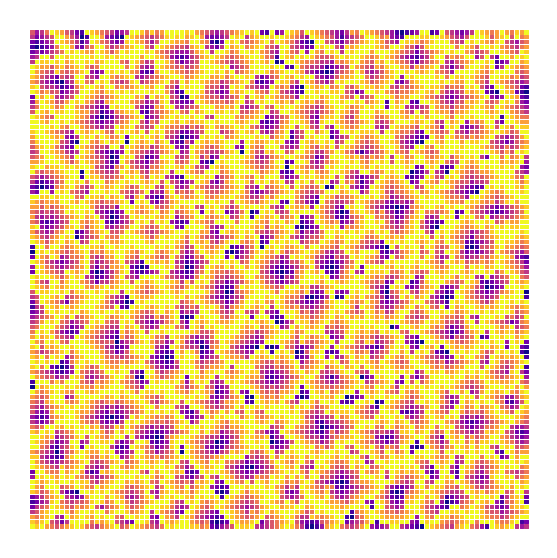

In [39]:
def show(in9, low=None):
    plt.figure(figsize=(10, 10))
    C = [in9[p] for p in in9]
    plt.scatter(*transpose(in9), marker='s', s=10, c=C, cmap=plt.get_cmap('plasma'))
    if low: plt.plot(*transpose(low_points(in9)), low, markersize=4)
    plt.axis('square'); plt.axis('off')
    
show(in9)

We can optionally display the low points. Here I'll display them as black diamonds:

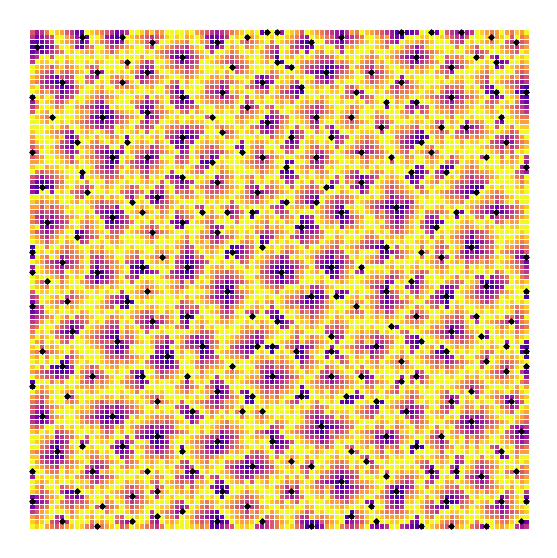

In [40]:
show(in9, 'kD')

Apropos to *Smoke* and *Water,* and to the color scheme of my plot, Gary Grady's drawing for the day references  [Deep Purple](https://www.youtube.com/watch?v=_zO6lWfvM0g):

<img src="https://pbs.twimg.com/media/FGL7YhbX0BAHDDt?format=jpg&name=medium" title="@GaryJGrady" width=400>

# [Day 10](https://adventofcode.com/2021/day/10): Syntax Scoring

- **Input**: Each entry in the input is a string of opening and closing brackets: `[({<` and `>})]`.


In [41]:
in10 = parse(10)

----------------------------------------------------------------------------------------------------
AOC2021/input10.txt ➜ 10196 chars, 102 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
[(([{<{(<{{[({{}{}}{[]()})<{{}()}>]}}(([{{{}[]}[[]()]}[<{}[]]{()()}]](({{}{}}{{}()}))){[{({}())[[
<(({[<([{({[{{<>()}}[{<>()}({}{})]]<{<()<>>{[]()}}(((){}>[[][]])>}([{<[]{}>(<>[])}]))<[[[[[][]
(<<(<{{{{<<<[(()<>){()<>}][[()()]]>{<{[]{}}<<>()>>}>{(<{<>}([]{})><(<> ... []{})(()()))<<()[]>{{}[]}
[[[[<[{[(<{{{({}<>)((){})}((()())[()()])}}><[([((){})]<[()[]]{{}<>}>)[[{[]<>}][([]{})[{}()]]]]>)<{(<
[<(<[[((<{((<<<>[]>><<<>{}>>){<[{}<>][<>[]]><<<>()>[(){}]>})[<{[{}<>][(){}]}<[[]<>][{}[]])>{([<>[]][
(([[[[<([[{([{<>()}{()<>}][((){})]){[{[]<>}({}<>)][(<><>)[()[]]]}}<{{({}{}){[]{}}}<{<><>}({}{})>}>
{{{[<(<([<{({{[]()}[{}()]}{<()<>>(()<>)})}><<[{<()()>(()[])}<<<>[]]>][<{()}{<><>}>({{}[]})]>>](
----------------------------------------------

Ideally, the brackets are balanced, but entries might be *corrupted* (an extra closing bracket of the wrong kind appears in the wrong place) or *incomplete* (one or more closing brackets are missing from the end).
  
- **Part 1**: Find the first illegal character in each corrupted line of the navigation subsystem. What is the total syntax error score for those errors?


The instructions for Part 1 say *Some of the lines aren't corrupted, just incomplete; you can ignore these lines for now.* That suggests we will not ignore the incomplete lines in Part 2. So I'll define `analyze_syntax` to return a tuple of two values: an error score for use in Part 1, and the missing characters for an incomplete line, which I suspect will be used in Part 2.

In [42]:
error_scores = {')': 3, ']': 57, '}': 1197, '>': 25137}
open_close   = {'(': ')', '[': ']', '{': '}', '<': '>'}

def analyze_syntax(line) -> Tuple[int, str]:
    """A tuple of (error_score, missing_chars) for this line."""
    stack = [''] # A stack of closing characters we are looking for.
    for c in line:
        if c == stack[-1]:     # A correctly matched closing bracket
            stack.pop()
        elif c in open_close:  # A new opening bracket
            stack.append(open_close[c])
        else:                  # An erroneous closing bracket
            return error_scores[c], cat(reversed(stack))
    return 0, cat(reversed(stack))
        
answer(10.1, sum(analyze_syntax(line)[0] for line in in10), 367059)

True

- **Part 2**: Find the completion string for each incomplete line, score the completion strings, and sort the scores. What is the middle score?

I was right; Part 2 uses the missing characters (now called a *completion string*). To score the completion string, we  treat it as a base-5 number, as shown in `completion_score`.

In [43]:
def completion_score(completion:str) -> int:
    """The completion score for the completion string (the missing characters)."""
    score = completion.translate(str.maketrans(')]}>', '1234'))
    return int(score, base=5)

def median_completion_score(lines) -> int:
    """The median completion score out of all the uncorrupted lines."""
    scores = (completion_score(completion) 
              for e, completion in map(analyze_syntax, lines) 
              if e == 0)
    return median(scores)

answer(10.2, median_completion_score(in10), 1_952_146_692)

True

# [Day 11](https://adventofcode.com/2021/day/11): Dumbo Octopus

- **Input**: The input is a 2D array of characters `0`–`9` representing the energy levels of bioluminescent [dumbo octopuses](https://www.youtube.com/watch?v=eih-VSaS2g0).

In [44]:
in11 = Grid(rows=parse(11, digits), neighbors=neighbors8)

----------------------------------------------------------------------------------------------------
AOC2021/input11.txt ➜ 110 chars, 10 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
1224346384
5621128587
6388426546
1556247756
1451811573
1832388122
2748545647
----------------------------------------------------------------------------------------------------
parse(11) ➜ 10 entries:
----------------------------------------------------------------------------------------------------
((1, 2, 2, 4, 3, 4, 6, 3, 8, 4), (5, 6, 2, 1, 1, 2, 8, 5, 8, 7), (6, 3 ...  2, 4, 8, 7, 6, 6, 2, 7))
----------------------------------------------------------------------------------------------------


- **Part 1**: Given the starting energy levels of the dumbo octopuses in your cavern, simulate 100 steps. How many total flashes are there after 100 steps?

On each step, each octopus increases by one energy unit; then the ones with an energy level over 9 emit a flash, which makes their neighbors get one more energy unit (potentially causing others to flash); then the flashers reset to zero energy.

In [45]:
def simulate_flashes(grid, steps=100) -> int:
    """Simulate octopus flashes for `steps` steps and return total number of flashes."""
    grid = grid.copy() # Don't mutate the original grid
    flashes = 0
    for step in range(steps):
        flashers = set()
        for p in grid:
            grid[p] += 1
        for p in grid:
            check_flash(grid, p, flashers)
        for p in flashers:
            grid[p] = 0
        flashes += len(flashers)
    return flashes

def check_flash(grid, p, flashers):
    """Check if grid[p] flashes, and if so, recursively spread."""
    if grid[p] > 9 and p not in flashers:
        flashers.add(p)
        for p2 in grid.neighbors(p):
            grid[p2] += 1
            check_flash(grid, p2, flashers)
    
answer(11.1, simulate_flashes(in11, 100), 1591)

True

- **Part 2**: If you can calculate the exact moments when the octopuses will all flash simultaneously, you should be able to navigate through the cavern. What is the first step during which all octopuses flash?

I feel a bit bad that I have to copy/paste/edit the whole simulation function, changing just the number of steps and the return. But at least I don't have to copy the  `check_flash` function.

In [46]:
def simulate_flashes2(grid) -> int:
    """Simulate octopus flashes and return the first step during which all octopuses flash."""
    grid = grid.copy() # Don't mutate the original grid
    for step in count_from(1):
        flashers = set()
        for p in grid:
            grid[p] += 1
        for p in grid:
            check_flash(grid, p, flashers)
        for p in flashers:
            grid[p] = 0
        if len(flashers) == len(grid):
            return step
        
answer(11.2, simulate_flashes2(in11), 314)

True

<img src="https://pbs.twimg.com/media/FGWQiIuXMAUK_aH?format=jpg&name=medium" width=400 title="@GaryJGrady">

# [Day 12](https://adventofcode.com/2021/day/11): Passage Pathing

- **Input**: Each entry in the input is a connection between two caves. Big caves are written in uppercase, small caves in lowercase. `start` and `end` are two special caves with the obvious meaning.

In [47]:
in12 = parse(12, words)

----------------------------------------------------------------------------------------------------
AOC2021/input12.txt ➜ 144 chars, 22 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
xx-xh
vx-qc
cu-wf
ny-LO
cu-DR
start-xx
LO-vx
----------------------------------------------------------------------------------------------------
parse(12) ➜ 22 entries:
----------------------------------------------------------------------------------------------------
(['xx', 'xh'], ['vx', 'qc'], ['cu', 'wf'], ['ny', 'LO'], ['cu', 'DR'], ... xh', 'DR'], ['cu', 'xh'])
----------------------------------------------------------------------------------------------------


- **Part 1**: How many paths through this cave system are there that visit small caves at most once?

My approach is as follows:
- I'll define a path as a list of cave names: `['start', ..., 'end']`.
- I'll construct `neighbors` as a mapping from a cave to the list of caves it connects to.
- I'll do depth-first search, starting from the trivial path `['start']` and returning all possible paths.  

In [48]:
Path = List[str]
    
def search_paths(path, neighbors) -> Iterable[Path]:
    """All paths that start with `path` and lead to 'end' using `neighbors`.
    Small caves can only be visited once."""
    if path[-1] == 'end':
        yield [path]
    else:
        for cave in neighbors[path[-1]]:
            if cave.isupper() or cave not in path:
                yield from search_paths(path + [cave], neighbors)

neighbors = multimap(in12, symmetric=True)
                     
answer(12.1, quantify(search_paths(['start'], neighbors)), 4167)

True

- **Part 2**: After reviewing the available paths, you realize you might have time to visit a single small cave twice.  However, the caves named `start` and `end` can only be visited exactly once each. Given these new rules, how many paths through this cave system are there?

At first I felt bad that I would again have to copy/paste/edit the code for Part 1. I felt better when I realized that the revised function `search_paths2` would have need to call the original `search_paths`: once the path returns to a small cave for the second time, the remainder of the search should be under the `search_paths` rules, not the `search_paths2` rules.

In [49]:
def search_paths2(path, neighbors):
    """Find all paths that start with `path` and lead to 'end' using `neighbors`.
    Small caves can only be visited once, except one of them may be visited twice."""
    if path[-1] == 'end':
        yield [path]
    else:
        for cave in neighbors[path[-1]]:
            if cave.isupper() or cave not in path:
                yield from search_paths2(path + [cave], neighbors)
            elif cave.islower() and cave != 'start':
                yield from search_paths(path + [cave], neighbors)
                            
answer(12.2, quantify(search_paths2(['start'], neighbors)), 98441)

True

# [Day 13](https://adventofcode.com/2021/day/13): Transparent Origami

- **Input**: The input is a set of dots, e.g. "`6,10`", followed by an ordered list of fold instructions, e.g. "`fold along y=7`".

My `parse` command is not set up to parse two different sections, so I'll ask `parse` only to parse each line into a tuple of atoms. Then I'll further process the entries to get two variables:
- `dots`: a set of `(x, y)` points, such as `(6, 10)`. 
- `folds`: a list of fold instructions such as `('fold', 'along', 'y', 7)`.

In [50]:
in13  = parse(13, atoms, sep='\n')

----------------------------------------------------------------------------------------------------
AOC2021/input13.txt ➜ 6424 chars, 789 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
103,224
624,491
808,688
1076,130
700,26
55,794
119,724
----------------------------------------------------------------------------------------------------
parse(13) ➜ 789 entries:
----------------------------------------------------------------------------------------------------
((103, 224), (624, 491), (808, 688), (1076, 130), (700, 26), (55, 794) ... 'fold', 'along', 'y', 6))
----------------------------------------------------------------------------------------------------


In [51]:
dots  = {entry for entry in in13 if len(entry) == 2} 
folds = [entry for entry in in13 if len(entry) > 2]
folds

[('fold', 'along', 'x', 655),
 ('fold', 'along', 'y', 447),
 ('fold', 'along', 'x', 327),
 ('fold', 'along', 'y', 223),
 ('fold', 'along', 'x', 163),
 ('fold', 'along', 'y', 111),
 ('fold', 'along', 'x', 81),
 ('fold', 'along', 'y', 55),
 ('fold', 'along', 'x', 40),
 ('fold', 'along', 'y', 27),
 ('fold', 'along', 'y', 13),
 ('fold', 'along', 'y', 6)]

The idea of this puzzle is that the dots are on transparent paper, and when following the `fold along y=7` instruction, all the dots below the line `y=7` are reflected above the line: they retain the same distance form the `y=7` line, but their `y` value becomes less than `7`. Similarly, for an `x` fold, all the points to the right of the line are reflected to the left. When we finish the folds, a code message will appear.

- **Part 1**: How many dots are visible after completing just the first fold instruction on your transparent paper?

In [52]:
def fold(dots, instruction) -> Set[Point]: 
    """The set of dots that result from following the fold instruction."""
    fold, along, x_or_y, line = instruction
    if x_or_y == 'x':
        return {(line - abs(line - x), y) for (x, y) in dots}
    else:
        return {(x, line - abs(line - y)) for (x, y) in dots}

In [53]:
answer(13.1, len(fold(dots, folds[0])), 638)

True

- **Part 2**: Finish folding the transparent paper according to the instructions. What is the code?

In [54]:
def origami(dots, instructions) -> None:
    """Follow all the instructions and plot the resulting dots."""
    for instruction in instructions:
        dots = fold(dots, instruction)
    plt.scatter(*transpose(dots), marker='s')
    plt.axis('equal'); plt.gca().invert_yaxis()

True

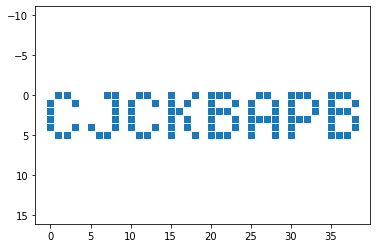

In [55]:
answer(13.2, origami(dots, folds), None) # actual answer: "CJCKBAPB"

I kind of cheated here. I didn't want to write an OCR program, so I relied on my own eyes to look at the dots and see the code.

**Note**: My transparent paper was folded 12 times. Is that physically feasible? [Britney Gallivan](https://www.youtube.com/watch?v=AfPDvhKvaa0&) says yes (barely).

# [Day 14](https://adventofcode.com/2021/day/14): Extended Polymerization

- **Input**: The input is a a polymer template (a string of one-letter element names, such as "`NNCB`") followed by a list of pair insertion rules (such as "`CH -> B`", meaning that a `B` should be inserted into the middle of each `CH` pair).

I'll parse each line of the input into a list of `words` (thus ignoring the "`->`" characters); then pick out:
- `polymer`: the sole word on the first line.
- `rules`: the third through last lines, converted into a dict, like `{'CH': 'B', ...}`.

In [56]:
in14    = parse(14, words)
polymer = in14[0][0]
rules   = dict(in14[2:])

----------------------------------------------------------------------------------------------------
AOC2021/input14.txt ➜ 822 chars, 102 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
ONSVVHNCFVBHKVPCHCPV

VO -> C
VV -> S
HK -> H
FC -> C
VB -> V
----------------------------------------------------------------------------------------------------
parse(14) ➜ 102 entries:
----------------------------------------------------------------------------------------------------
(['ONSVVHNCFVBHKVPCHCPV'], [], ['VO', 'C'], ['VV', 'S'], ['HK', 'H'],  ... ['FO', 'C'], ['VS', 'B'])
----------------------------------------------------------------------------------------------------


- **Part 1**: Apply 10 steps of pair insertion to the polymer template and find the most and least common elements in the result. What do you get if you take the quantity of the most common element and subtract the quantity of the least common element?

Pair insertion means inserting the element on the right hand side of a rule between each two-element pair. All two-element substrings are considered as pairs (that is, the pairs overlap). All insertions happen simultaneously during a step.

In [57]:
def pair_insertion(polymer, rules, steps) -> str:
    """Insert elements into polymer according to rules; repeat `steps` times."""
    for _ in range(steps):
         polymer = cat(pair[0] + rules[pair]
                       for pair in pairs(polymer)) + polymer[-1]
    return polymer

def pairs(seq) -> list: return [seq[i:i+2] for i in range(len(seq) - 1)]

def quantity_diff(polymer) -> int:
    """The count of most common element minus the count of least common element."""
    counts = list(Counter(polymer).values())
    return max(counts) - min(counts)

assert pairs('NNCB') == ['NN', 'NC', 'CB']
assert pair_insertion('NNCB', rules={'NN': 'C', 'NC': 'B', 'CB': 'H'}, steps=1) == 'NCNBCHB'

answer(14.1, quantity_diff(pair_insertion(polymer, rules, 10)), 3259)

True

- **Part 2**: Apply 40 steps of pair insertion to the polymer template and find the most and least common elements in the result. What do you get if you take the quantity of the most common element and subtract the quantity of the least common element?

The instructions warn us that the resulting polymer after 40 steps will be *trillions* of elements long. So it isn't feasible to just call `pair_insertion` with steps=40. Instead, I'll employ the same trick as in Day 6: use a `Counter` of element pairs so that, for example, all the `'NC'` pairs in the polymer are handled simultaneously in one operation, rather than handling each one individually. No matter how many steps we do, there are only 100 distinct element pairs, so iterating over them 40 times should be very fast. 

Here's an example Counter of element pairs:

In [58]:
Counter(pairs('NNCB'))

Counter({'NN': 1, 'NC': 1, 'CB': 1})

What letters does this represent? The complication is that the pairs overlap, so, if we added up the counts for all the times that, say, the letter `'C'` appears in keys of the Counter, we'd get 2; but it should be 1. We can divide each letter count by 2 to avoid double counting. However the first and last letters in the polymer are *not* double-counted, so we need to add back 1/2 for each of those letters. Fortunately the first and last letters are invariant under pair insertion, so we can do this adjustment at the end; we don't have to do it for each step.

So all in all there are three representations of a polymer:

In [59]:
Polymer       = str           # e.g. 'NNCB'
PairCounter   = Counter[str]  # e.g. Counter({'NN': 1, 'NC': 1, 'CB': 1})
LetterCounter = Counter[Char] # e.g. Counter({'N': 2, 'C': 1, 'B': 1})

Here's how we convert a PairCounter into a LetterCounter:

In [60]:
def letter_counts(pair_ctr: PairCounter, polymer: Polymer) -> LetterCounter:
    """Return a Counter of the letters in the polymer described by the `pair_ctr`."""
    letters = set(flatten(pair_ctr))
    def letter_count(L) -> int:
        return int(sum(pair_ctr[L+M] + pair_ctr[M+L] for M in letters) / 2
                   + (L == polymer[0]) / 2 + (L == polymer[-1]) / 2)
    return Counter({L: letter_count(L) for L in letters})

In [61]:
letter_counts(Counter(pairs('NNCB')), 'NNCB')

Counter({'B': 1, 'C': 1, 'N': 2})

Let's make sure it works when the first and last letters are the same:

In [62]:
assert letter_counts(Counter(pairs('NNCB')), 'NNCB') == letter_counts(Counter(pairs('NCBN')), 'NCBN')

Now the new function `pair_insertion_diff` can call on `pair_insertion2` to solve Part 2 (as well as Part 1):

In [63]:
def pair_insertion2(polymer, rules, steps) -> PairCounter:
    """Insert elements into polymer according to rules; repeat `steps` times.
    Return a Counter of element pairs."""
    pair_ctr = Counter(pairs(polymer))
    for _ in range(steps):
        pair_ctr2 = Counter()
        for LM in pair_ctr:
            pair_ctr2[LM[0] + rules[LM]] += pair_ctr[LM]
            pair_ctr2[rules[LM] + LM[1]] += pair_ctr[LM]
        pair_ctr = pair_ctr2
    return pair_ctr

def pair_insertion_diff(polymer, rules, steps):
    """Most common minus least common after `steps` of pair insertion."""
    return quantity_diff(letter_counts(pair_insertion2(polymer, rules, steps), polymer))

assert Counter(pairs('NNCB')) == Counter({'NN': 1, 'NC': 1, 'CB': 1})
assert pair_insertion2('NNCB', rules={'NN': 'C', 'NC': 'B', 'CB': 'H'}, steps=1) == (
       Counter({'NC': 1, 'CN': 1, 'NB': 1, 'BC': 1, 'CH': 1, 'HB': 1}))
assert letter_counts(Counter({'NC': 1, 'CN': 1, 'NB': 1, 'BC': 1, 'CH': 1, 'HB': 1}), 'NNCB') == (
       Counter({'N': 2, 'C': 2, 'B': 2, 'H': 1}))
assert pair_insertion_diff('NNCB', rules={'NN': 'C', 'NC': 'B', 'CB': 'H'}, steps=1) == 1

answer(14.1, pair_insertion_diff(polymer, rules, 10), 3_259)
answer(14.2, pair_insertion_diff(polymer, rules, 40), 3_459_174_981_021)

True

- **Part 3**: Polymer length?

The instructions didn't ask, but I want to know the length of the polymer that was created after 40 steps. The calculation  below says over 20 trillion.

In [64]:
length = total(pair_insertion2(polymer, rules, 40))
print(f'{length:,d}')

20,890,720,927,744


# [Day 15](https://adventofcode.com/2021/day/15): Chiton

- **Input**: The input is a square grid of *risk levels* (each one digit, 1–9) for locations in the cave.

In [65]:
in15 = Grid(rows=parse(15, digits))

----------------------------------------------------------------------------------------------------
AOC2021/input15.txt ➜ 10100 chars, 100 lines; first 7 lines:
----------------------------------------------------------------------------------------------------
4249856395422795894919869133487611581179923326874763428673979547991221931142777981153991369468629849
5812974178739823463799939791688998895568796557798392761499941349143539572865883254186633218867928826
3699989976298596286299499129934993241824395574879938998946914116375199242199151918863674914554714898
5682435936794718871685718386458294198391116125679589438794914499278679393779734596558953699438589518
7681197997388219696918569664119968498599547892968929425479817979816979144947916716989874825679487436
9981166198272997899142698141878643123757515999788822988261499197559193945291512682763935126815448215
8849481991861599951293183728419792414164347979985169641698899853377259811688489269959429131918919179
------------------------------

- **Part 1**: You start in the top left position, your destination is the bottom right position, and you cannot move diagonally. What is the lowest total risk of any path from the top left to the bottom right? (Don't count the risk level of your starting position.)

Gary Grady's drawing represents the risk involved in finding a path that avoids bumping into the ceiling above or the chitons below.

<img src="https://pbs.twimg.com/media/FGrU-PKXIAQ6sa8?format=jpg&name=medium" width=400 title="@GaryJGrady">

I'll use a search that updates a grid of the `cost` of the best known path from start to each point. The cost for each point is initially infinite (because we don't know any paths), and is updated each time we find a better path to the point. Whenever we find a better path to a point, we see if that will lead to a better path for the neighbors.

In [66]:
def search_grid(grid, start=(0, 0), goal=None) -> int:
    """The total cost of the best path from start to goal (which defaults to bottom right)."""
    goal      = goal or max(grid) # default bottom right
    path_cost = Grid({p: inf for p in grid}) # cost of best known path from start to p
    frontier  = {start} # Set of grid points to consider for possible improvement to path_cost
    while frontier:
        p = frontier.pop()
        new_cost = 0 if p is start else (grid[p] + min(path_cost[b] for b in grid.neighbors(p)))
        if new_cost < path_cost[p]:
            path_cost[p] = new_cost
            frontier.update(grid.neighbors(p))
    return path_cost[goal]

answer(15.1, search_grid(in15), 687)

True

- **Part 2**: The entire cave is actually five times larger in both dimensions. Your original map tile repeats to the right and downward; each time the tile repeats, all of its risk levels are 1 higher than the tile immediately up or left of it. However, risk levels above 9 wrap back around to 1. Using the full map, what is the lowest total risk of any path from the top left to the bottom right?

Here's how to define the full map of the cave:

In [67]:
def repeat_grid(grid, repeat=5):
    """Extend the grid to be `repeat` times larger in both directions.
    Values within each repeated block are increased by 1 for each repetition to the right or down,
    but values over 9 wrap around to 1."""
    w, h = grid.width, grid.height 
    return Grid([(x + xr * w, y + yr * h), clock_mod(grid[x, y] + xr + yr, 9)]
                for xr in range(repeat) 
                for yr in range(repeat)
                for x, y in grid)

def clock_mod(i, m) -> int:
    """i % m, but replace a result of 0 with m"""
    # This is like a clock, where 24 mod 12 is 12, not 0.
    return (i % m) or m

In [68]:
full_map = repeat_grid(in15, 5)
len(full_map)

250000

With 250,000 points in the full map, `search_grid` takes about 5 minutes (I tried it). That's too slow, so I grabbed the [A* search](https://en.wikipedia.org/wiki/A*_search_algorithm) from my [AoC 2017](https://github.com/norvig/pytudes/blob/main/ipynb/Advent%202017.ipynb) notebook, and supplied it with the proper functions to make a move, compute the cost of a move, and estimate the distance to the goal (the `h_func` or "heuristic function"). A* is guaranteed to find an optimal path if the heuristic function never overestimates the cost from a state to the goal, so I will use the [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) as my heuristic–this is the same as assuming that every risk level in the remainder of the path will be 1, the lowest possible.

In [69]:
from heapq import heappop, heappush

def Astar(start, neighbors, h_func, step_cost) -> Tuple[int, list]:
    """Find a (cost, path) tuple for the lowest-cost path from start to a goal.
    A goal is any state `s` such that `h_func(s) == 0`."""
    frontier  = [(h_func(start), start)] # A priority queue, ordered by path_cost(s) + h(s)
    previous  = {start: None}  # start state has no previous state; other states will
    path_cost = {start: 0}     # The cost of the best path to a state.
    Path      = lambda s: ([] if (s is None) else Path(previous[s]) + [s])
    while frontier:
        (f, s) = heappop(frontier)
        if h_func(s) == 0:
            return path_cost[s], Path(s)
        for s2 in neighbors(s):
            g = path_cost[s] + step_cost(s, s2)
            if s2 not in path_cost or g < path_cost[s2]:
                heappush(frontier, (g + h_func(s2), s2))
                path_cost[s2] = g
                previous[s2] = s
                
def Astar_search_grid(grid, start=(0, 0))  -> Tuple[int, list]:
    """The (risk, path) tuple of the best path from start to bottom-right on grid."""
    goal = max(grid)
    def neighbors(s): return grid.neighbors(s) # possible moves
    def h_func(s): return sum(goal) - sum(s)    # estimated path cost from s to goal
    def step_cost(_, s2): return grid[s2]       # cost of moving to s2
    return Astar(start, neighbors, h_func, step_cost)

With A* search the run time is greatly improved, from 5 minutes down to about 1 second.

In [70]:
answer(15.2, Astar_search_grid(full_map)[0], 2957)

True

- **Part 3**: Visualization

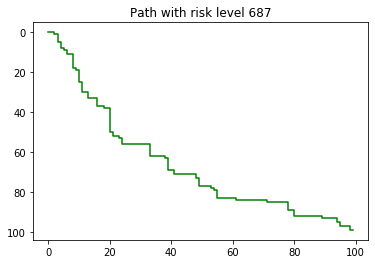

In [71]:
def plot_search_grid(grid, fmt='g-'):
    """PLot the path from start to goal."""
    risk, path = Astar_search_grid(grid)
    plt.plot(*transpose(path), fmt); plt.gca().invert_yaxis()
    plt.title(f'Path with risk level {risk}')
    
plot_search_grid(in15)

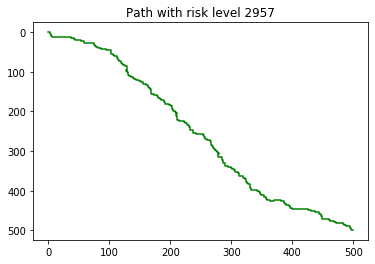

In [72]:
plot_search_grid(full_map)

# [Day 16](https://adventofcode.com/2021/day/16): Packet Decoder

- **Input**: The input is a single line containing a sequence of hexadecimal digits, a message using the Buoyancy Interchange Transmission System (BITS). 

<img src="https://pbs.twimg.com/media/FGwEUnEWYAE5SVJ?format=jpg&name=medium" width=400 title="@GaryJGrady">

For now I will leave the input as a string of hex digits:

In [73]:
in16 = parse(16)[0]

----------------------------------------------------------------------------------------------------
AOC2021/input16.txt ➜ 1307 chars, 1 lines; first 1 lines:
----------------------------------------------------------------------------------------------------
220D790065B2745FF004672D99A34E5B33439D96CEC80373C0068663101A98C406A5E7 ... 97652008065992443E7872714
----------------------------------------------------------------------------------------------------
parse(16) ➜ 1 entries:
----------------------------------------------------------------------------------------------------
('220D790065B2745FF004672D99A34E5B33439D96CEC80373C0068663101A98C406A5 ... 52008065992443E7872714',)
----------------------------------------------------------------------------------------------------


- **Part 1:** The puzzle is to parse this hexadecimal transmission into data packets, according to the rules contained in [the instructions](https://adventofcode.com/2021/day/16), and add up all of the version numbers of the packets.

The gist of [the instructions](https://adventofcode.com/2021/day/16) is to consider the hexadecimal sequence as a bit string, divide the bit string into bit fields, and construct nested packets based on the values of the fields. Here are basic types for `Bits` (a bit string) and `Packet` (which contains a version number `V`, a type ID `T`, and a `contents` field which can be either a number or a list of packets), along with functions to convert from a hexadecimal string to a bit string, and from there to an int: 

In [74]:
Bits   = str # a string of '0's and '1's
Packet = namedtuple('Packet', 'V, T, contents') # V is version; T is type ID

def bits_from_hex(hex) -> Bits: 
    """Convert a hexadecimal string into a bit string, making sure each hex digit is 4 bits."""
    # I could have used just `bin(int(hex, 16))`, except that wouldn't left-zero-pad when needed.
    return cat(f'{int(x, 16):04b}' for x in hex)

def int2(bits: Bits) -> int: 
    """Convert a bit string into an int."""
    return int(bits, 2)

To parse the bit string into packets, I will have four functions that start with the word `parse_` and return a tuple of two values: the object parsed (either an int or a packet) and the remaining bits that were not parsed.

In [75]:
def parse_int(L, bits) -> Tuple[int, Bits]:
    """Parse an integer from the first L bits; return the int and the remaining bits."""
    return int2(bits[:L]), bits[L:]

def parse_packet(bits) -> Tuple[Packet, Bits]:
    """Parse a packet; return it and the remaining bits."""
    V, T, bits = int2(bits[0:3]), int2(bits[3:6]), bits[6:]
    parser = parse_literal_packet if T == 4 else parse_operator_packet
    return parser(V, T, bits)
        
def parse_literal_packet(V, T, bits) -> Tuple[Packet, Bits]:
    """Build a packet with a literal value; return it and the remaining bits."""
    literal = ''
    while True:
        prefix, group, bits = bits[0], bits[1:5], bits[5:]
        literal += group
        if prefix == '0':
            return Packet(V, T, int2(literal)), bits

def parse_operator_packet(V, T, bits) -> Tuple[Packet, Bits]:
    """Build a packet with subpackets; return it and the remaining bits."""
    I, bits = parse_int(1, bits)
    L, bits = parse_int((15, 11)[I], bits)
    subpackets = []   
    if I == 0: # Parse L bits of subpackets
        subpacket_bits, bits = bits[:L], bits[L:]
        while subpacket_bits:
            packet, subpacket_bits = parse_packet(subpacket_bits)
            subpackets.append(packet)
    else: # Parse L subpackets
        for p in range(L):
            packet, bits = parse_packet(bits)
            subpackets.append(packet)        
    return Packet(V, T, subpackets), bits

Now we're ready to solve the puzzle by summing up the version numbers, `V`, of all the packets:

In [76]:
def nested_packets(packet) -> Iterator[Packet]: 
    """The packet and all its subpackets."""
    yield packet
    if packet.T != 4: 
        for p in packet.contents:
            yield from nested_packets(p)

packet16, _ = parse_packet(bits_from_hex(in16))
answer(16.1, sum(p.V for p in nested_packets(packet16)), 989)

True

This was way more code than previous days! Here are some assertions I used to make sure I was on the right track:

In [77]:
assert (bits_from_hex('D2FE28') 
        == '110100101111111000101000')

assert (int2(bits_from_hex('D2FE28'))
        == 13827624)

assert (bits_from_hex('38006F45291200') 
        == '00111000000000000110111101000101001010010001001000000000')

assert (parse_int(4, '011100111') 
        == (7, '00111'))

assert (parse_packet('110100101111111000101000') 
        == parse_literal_packet(6, 4, '101111111000101000')
        == (Packet(V=6, T=4, contents=2021), '000'))

assert (parse_packet('00111000000000000110111101000101001010010001001000000000')
        == (Packet(V=1, T=6, contents=[Packet(V=6, T=4, contents=10), 
                                       Packet(V=2, T=4, contents=20)]),
            '0000000'))

assert (parse_packet('11101110000000001101010000001100100000100011000001100000')
        == (Packet(V=7, T=3, contents=[Packet(V=2, T=4, contents=1), 
                                       Packet(V=4, T=4, contents=2), 
                                       Packet(V=1, T=4, contents=3)]),
            '00000'))

- **Part 2**: What do you get if you evaluate the expression represented by your hexadecimal-encoded BITS transmission?

The evaluation rules are that a literal packet evaluates to the number that is its contents, and an operator packet applies an operator determined by the type id (in the `packet.T` field) to the list of values formed by evaluating the subpackets. I put the operators into the `packet_ops` dict.

In [78]:
def eval_packet(packet) -> int:
    """Evaluate a packet according to the operator rules."""
    if packet.T == 4:
        return packet.contents
    else:
        vals = [eval_packet(p) for p in packet.contents]
        return packet_ops[packet.T](vals)
    
packet_ops = {0: sum, 1: prod, 2: min, 3: max, 
              5: lambda v: int(v[0] > v[1]), 
              6: lambda v: int(v[0] < v[1]), 
              7: lambda v: int(v[0] == v[1])}

answer(16.2, eval_packet(packet16), 7936430475134)

True

# [Day 17](https://adventofcode.com/2021/day/17): Trick Shot

- **Input**: The input is a short string describing the x and y coordinates of a target area.

Because the input is so short, I will copy it literally here instead of reading it from a file. I use `ints` to extract the four integers.

In [79]:
in17 = ints("target area: x=257..286, y=-101..-57")

The puzzle involves firing a probe and checking if it hits the target area. The probe starts from an initial position with an initial velocity, and traverses a path according to the physics described in the instructions.

- **Part 1**: Find the initial velocity that causes the probe to reach the highest `y` position and still eventually be within the target area after some time step. What is the highest `y` position it reaches on this trajectory?

First I'll define two classes:
- `Target` keeps track of the `Xs` and `Ys` that define the target area.
- `Probe` keeps track of:
  - The `x` and `y` position coordinates
  - The `vx` and `vy` velocity values
  - A boolean `hit` which is True if the probe hit the target at some point in its path
  - The `highest` height it ever reached.

In [80]:
class Target:
    """The target has a range of Xs and Ys coordinates."""
    def __init__(self, a, b, c, d): self.Xs, self.Ys = range(a, b + 1),range(c, d + 1) 
        
Probe = namedtuple('Probe', 'x, y, vx, vy, hit, highest', 
                   defaults=(0, 0, 0,  0,  False, 0))

target17 = Target(*in17)

The function `probe_step` simulates the physics of the world for one time step: incrementing the probe's position by its velocity vector,  changing the `xv` velocity due to drag and the `yv` velocity due to gravity, and tracking the `hit` and `highest` values.

The function `probe_steps` simulates for multiple time steps; until the probe has passed the target. 

In [81]:
def probe_step(probe, target) -> Probe:
    """Simulate the physics of the probe for one time step."""
    x, y, vx, vy, hit, highest = probe
    return Probe(x=x + vx, y=y + vy, 
                 vx=sign(vx) * (abs(vx) - 1), vy=vy - 1,
                 hit=hit or (x in target.Xs and y in target.Ys),
                 highest=max(highest, y + vy))

def probe_steps(probe, target=target17, do=nothing) -> Probe:
    """Simulate the probe until it passes the target.
    You can optionally `do` something to the probe on each time step."""
    maxx, miny = max(target.Xs), min(target.Ys)
    do(probe)
    while probe.x <= maxx and probe.y >= miny:
        probe = probe_step(probe, target)
        do(probe)
    return probe

For example:

In [82]:
probe_steps(Probe(vx=24, vy=5))

Probe(x=290, y=-90, vx=4, vy=-15, hit=True, highest=15)

By experimentation, I found that:
- Any `vx<23` will never reach the target (regardless of `vy`).
- A `vx=23` value means that the probe will have an `x` velocity of zero when it is inside the width of the target. 
- Any `vx>23` will eventually pass beyond the target width (and might or might not hit the target along the way). 
- This is because 23 is the only value that leads to a sequence of decreasing `vx` values adding up to an `x` position that is within the x=257..286 target area: 23 + 22 + 21 + ... + 2 + 1 = 276. (As with Day 7, we're dealing with triangular numbers.)  Here's the demonstration:

In [96]:
{vx: [sum(range(vx, 0, -1)), sum(range(vx, 0, -1)) in target17.Xs]
 for vx in [22, 23, 24]}

{22: [253, False], 23: [276, True], 24: [300, False]}

Specifying `do=print` is useful for experimentation:

In [84]:
probe_steps(Probe(vx=23, vy=7), do=print)

Probe(x=0, y=0, vx=23, vy=7, hit=False, highest=0)
Probe(x=23, y=7, vx=22, vy=6, hit=False, highest=7)
Probe(x=45, y=13, vx=21, vy=5, hit=False, highest=13)
Probe(x=66, y=18, vx=20, vy=4, hit=False, highest=18)
Probe(x=86, y=22, vx=19, vy=3, hit=False, highest=22)
Probe(x=105, y=25, vx=18, vy=2, hit=False, highest=25)
Probe(x=123, y=27, vx=17, vy=1, hit=False, highest=27)
Probe(x=140, y=28, vx=16, vy=0, hit=False, highest=28)
Probe(x=156, y=28, vx=15, vy=-1, hit=False, highest=28)
Probe(x=171, y=27, vx=14, vy=-2, hit=False, highest=28)
Probe(x=185, y=25, vx=13, vy=-3, hit=False, highest=28)
Probe(x=198, y=22, vx=12, vy=-4, hit=False, highest=28)
Probe(x=210, y=18, vx=11, vy=-5, hit=False, highest=28)
Probe(x=221, y=13, vx=10, vy=-6, hit=False, highest=28)
Probe(x=231, y=7, vx=9, vy=-7, hit=False, highest=28)
Probe(x=240, y=0, vx=8, vy=-8, hit=False, highest=28)
Probe(x=248, y=-8, vx=7, vy=-9, hit=False, highest=28)
Probe(x=255, y=-17, vx=6, vy=-10, hit=False, highest=28)
Probe(x=261, y

Probe(x=276, y=-108, vx=0, vy=-17, hit=True, highest=28)

Once I found the critical `vx=23` value, I figured I could simply vary the `vy` values to find the highest height:

In [85]:
def highest_height(vxs=[23], vys=[]) -> int:
    """The highest height reached by a probe that hits the target, among all vx and vy values."""
    probes = [probe_steps(Probe(vx=vx, vy=vy)) for vx in vxs for vy in vys]
    return max(probe.highest for probe in probes if probe.hit)
    
answer(17.1, highest_height(vys=range(150)), 5050)

True

- **Part 2**: How many distinct initial velocity values cause the probe to be within the target area after some time step?
    
I can try a bunch of `vx` and `vy` values. For `vx`, start at the critical 23 value and go up to the maximum of the target area (meaning that the probe hits the right edge of the target area on the first time step). For `vy`, start with a negative value that would hit the bottom of the target area on the first time step, and go up to 100. (Anything more than that passes through the target without touching it: the probe's `y` value is higher than the target on one step and lower on the next.)

In [98]:
def probe_hits(vxs=range(23, max(target17.Xs) + 1), vys=range(min(target17.Ys), 101)) -> int:
    """How many of these velocities cause the probe to hit the target?"""
    return quantify(probe_steps(Probe(vx=vx, vy=vy)).hit 
                    for vx in vxs for vy in vys)

answer(17.2, probe_hits(), 2223)

True

- **Part 3**: Visualization

I'd like to understand things a bit better with some visualization. The function `plot_probes` plots the target as a black box and plots the paths of various probes with different initial velocities in different colors:

In [87]:
def plot_probes(velocities: List[Point], target=target17) -> None:
    """Plot the target as a black box and the paths of probes with colored lines."""
    x1, x2 = min(target.Xs), max(target.Xs)
    y1, y2 = min(target.Ys), max(target.Ys)
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'k-', linewidth=4)
    for (vx, vy) in velocities:
        path = []
        probe_steps(Probe(vx=vx, vy=vy), do=path.append)
        plt.plot([p.x for p in path], [p.y for p in path], '.:', label=f'({vx}, {vy})')
    plt.legend()

Below are four paths: two  that hit the target, and two that miss:

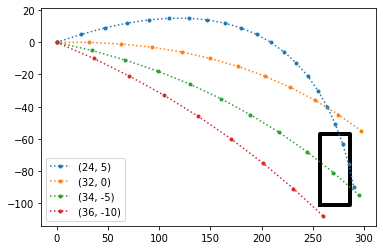

In [88]:
 plot_probes([(24, 5), (32, 0), (34, -5), (36, -10)])

Below we see that `vx=22` is doomed to stall before it reaches the target area; `vx=23` is the critical value that stalls and falls into the target area; and `vx=24` shoots beyond the target area before stalling.

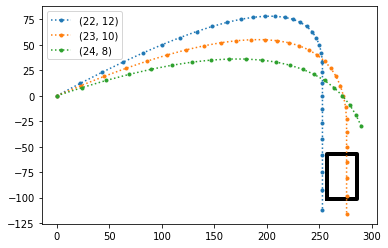

In [89]:
 plot_probes([(22, 12), (23, 10), (24, 8)])

Below is `vx=23`  paired with three different `vy` velocities:

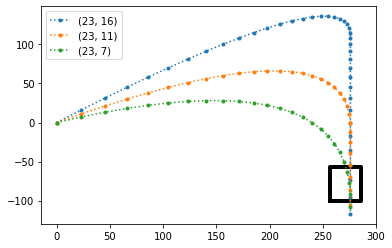

In [90]:
 plot_probes([(23, 16), (23, 11), (23, 7)])

When `vx < vy` the probe's path begins by bending up (e.g. for `(23, 32)`); when `vx = vy` the path is a straight line  (with ever-slowing speed); and when `vx > vy` the path bends down (e.g. for `(23, 8)`). But all paths eventually stall and fall due to drag.

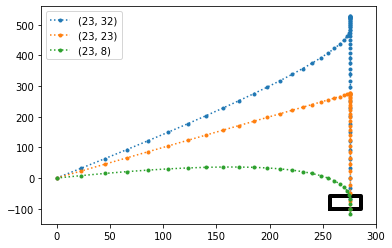

In [91]:
 plot_probes([(23, 32), (23, 23), (23, 8)])

Below, initial velocity `(23, 100)`, yields the high point of 5050 before stalling and falling into the target:

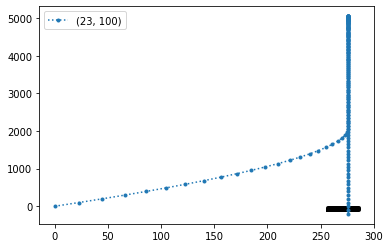

In [92]:
 plot_probes([(23, 100)])

Note the y-axis on this plot is ten times more than the previous plot. That's why the target box looks so squished and the path slope looks shallow. If we equalize the two axes, we can see how steep the slope is (and why this day is titled "Trick Shot"):

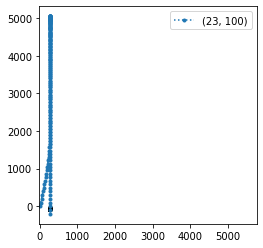

In [93]:
 plot_probes([(23, 100)]); plt.axis('square');

I can now see a more efficient way to deal with this problem:
  - The movement in  `x` and  `y` are independent, so we can treat them separately:
      - For each `vx`, determine in which time step(s) a probe could intersect `target.Xs`.
      - For each `vy`, determine in which time step(s) a probe could intersect `target.Ys`.
  - Now if a time step has 10 `vx` and 12 `vy` intersects, then that's 120 hits. 
  - The number of simulations we have to do is the sum of the lengths of `vxs` and `vys`, not their product.
  - This technique could have cut the number of simulations from about 50,000 to about 500. 
  - But 50,000 is a small number and the code runs in under a second, so we don't need a re-implementation